In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [5]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames# +hodnames

## Compare summaries

In [11]:
from collections import defaultdict

def load_diag(nbody, sim, lhid, a=0.666667, L=1000, N=128):
    diag_dir = join(wdir, nbody, sim, f'L{L}-N{N}/{lhid}', 'diag')
    if not os.path.exists(diag_dir):
        return None

    filepath = join(diag_dir, 'halos.h5')
    diag = {}
    with h5py.File(filepath, 'r') as f:
        for k, v in f[str(a)].items():
            diag[k] = v[:]
    return diag

# base sim
nbody = 'quijotelike'
sim = 'fastpm'
lhid = 20
a=f'{2/3:.6f}'
diag1 = load_diag(nbody, sim, lhid)
Pk_k3D = diag1['Pk_k3D']
Bk_k123 = diag1['Bk_k123']
zPk_k3D = diag1['zPk_k3D']
zBk_k123 = diag1['zBk_k123']

# iterate
keys = ['Pk', 'zPk', 'Bk', 'zBk', 'Qk', 'zQk']
r = {x: np.empty((2000, 2, *diag1[x].shape)) for x in keys}
for lhid in tqdm(range(2000)):
    nbody = 'quijotelike'
    sim = 'fastpm'
    diag1 = load_diag(nbody, sim, lhid)

    nbody='quijote'
    sim='nbody'
    diag2 = load_diag(nbody, sim, lhid)

    if diag1 is None or diag2 is None:
        continue
    for i, d in enumerate([diag1, diag2]):
        for k in r.keys():
            r[k][lhid][i] = d[k]


100%|██████████| 2000/2000 [07:11<00:00,  4.64it/s]


In [28]:
Bk_k123.shape

(3, 1444)

(0.8, 1.2)

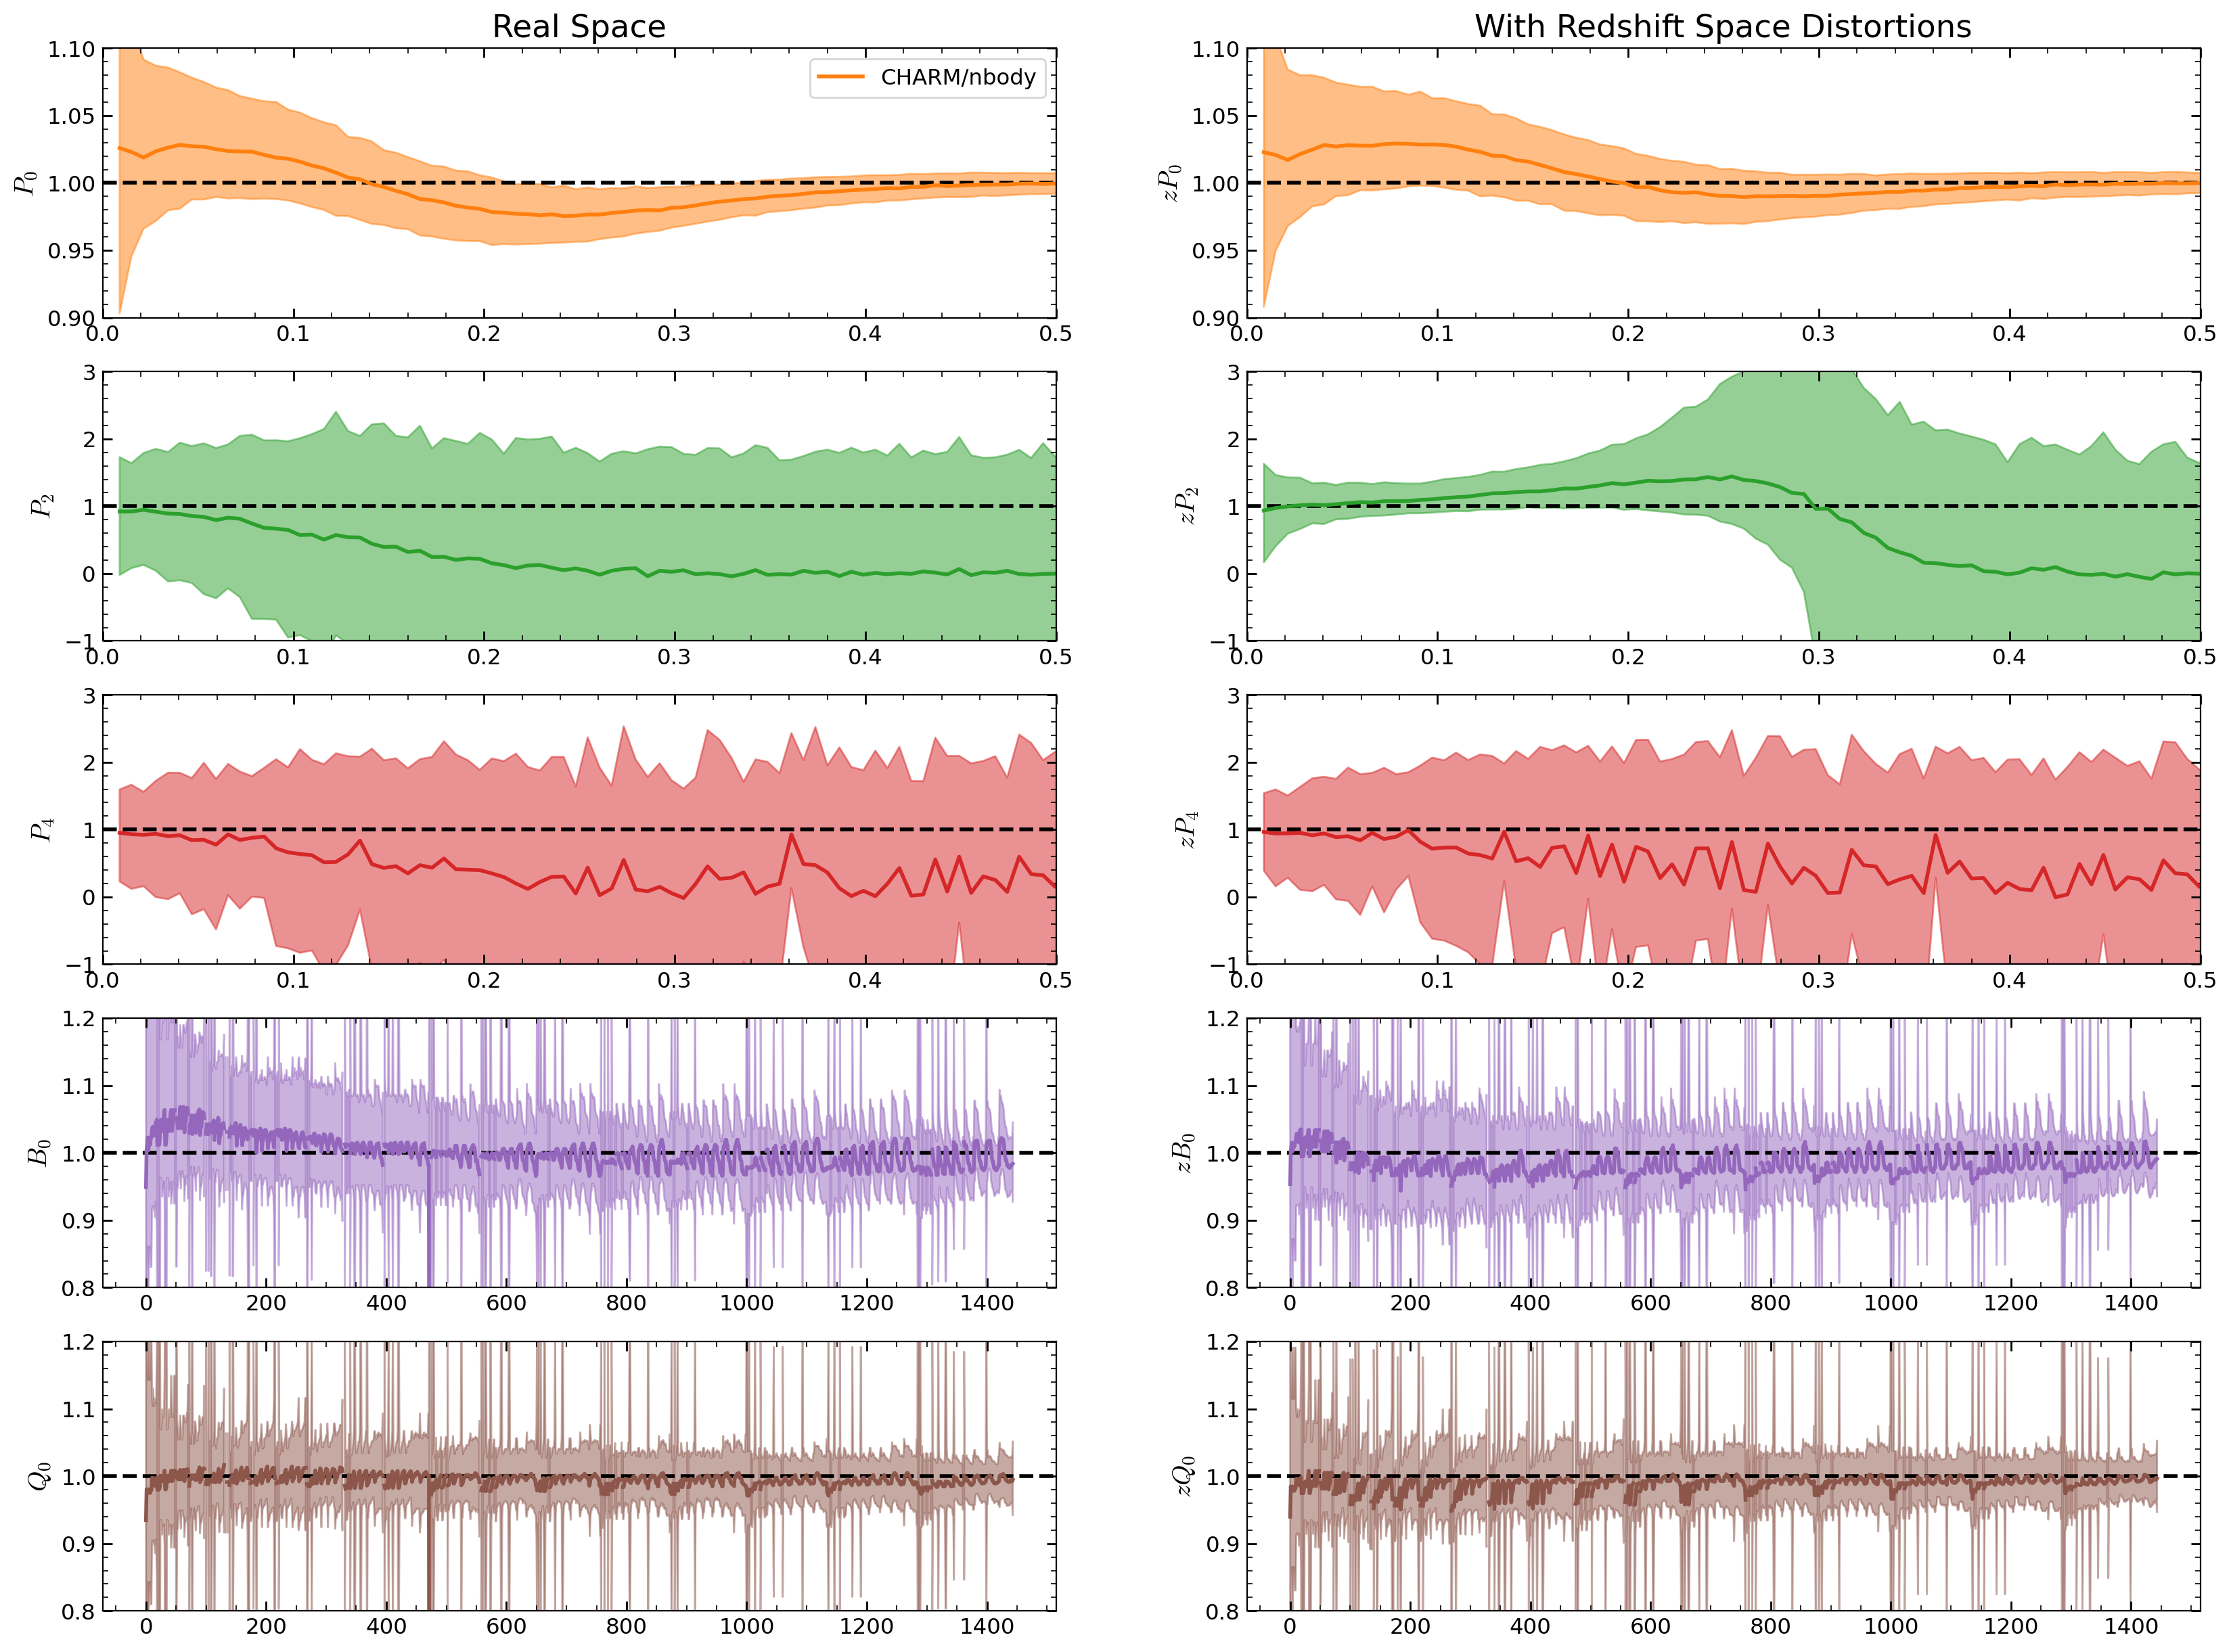

In [40]:
f, axs = plt.subplots(5, 2, figsize=(20, 15), sharex=False)

def plot_ratio(t, x, y, ax, percs=[16, 50, 84], label=None, **kwargs):
    ratio = x/y
    perc = np.percentile(ratio, percs, axis=0)
    ax.fill_between(t, perc[0], perc[2], alpha=0.5, **kwargs)
    ax.plot(t, perc[1], label=label, **kwargs)
    return perc

# Pk0
ax = axs[0,0]
# ax.semilogx()
ax.axhline(1, color='k', ls='--')
plot_ratio(Pk_k3D, r['Pk'][:,0,:,0], r['Pk'][:,1,:,0], ax, color='C1', label='CHARM/nbody')
ax.set_ylabel(r'$P_0$')
ax.legend()
ax.set_title('Real Space')
ax.set_xlim(0, 0.5)
ax.set_ylim(0.9, 1.1)

# zPk0
ax = axs[0,1]
# ax.semilogx()
ax.axhline(1, color='k', ls='--')
plot_ratio(zPk_k3D, r['zPk'][:,0,:,0], r['zPk'][:,1,:,0], ax, color='C1')
ax.set_ylabel(r'$zP_0$')
ax.set_title('With Redshift Space Distortions')
ax.set_xlim(0, 0.5)
ax.set_ylim(0.9, 1.1)

# Pk2
ax = axs[1,0]
# ax.semilogx()
ax.axhline(1, color='k', ls='--')
plot_ratio(Pk_k3D, r['Pk'][:,0,:,1], r['Pk'][:,1,:,1], ax, color='C2')
ax.set_ylabel(r'$P_2$')
ax.set_xlim(0, 0.5)
ax.set_ylim(-1, 3)

# zPk2
ax = axs[1,1]
# ax.semilogx()
ax.axhline(1, color='k', ls='--')
plot_ratio(zPk_k3D, r['zPk'][:,0,:,1], r['zPk'][:,1,:,1], ax, color='C2')
ax.set_ylabel(r'$zP_2$')
ax.set_xlim(0, 0.5)
ax.set_ylim(-1, 3)

# Pk4
ax = axs[2,0]
# ax.semilogx()
ax.axhline(1, color='k', ls='--')
plot_ratio(Pk_k3D, r['Pk'][:,0,:,2], r['Pk'][:,1,:,2], ax, color='C3')
ax.set_ylabel(r'$P_4$')
ax.set_xlim(0, 0.5)
ax.set_ylim(-1, 3)

# zPk4
ax = axs[2,1]
# ax.semilogx()
ax.axhline(1, color='k', ls='--')
plot_ratio(zPk_k3D, r['zPk'][:,0,:,2], r['zPk'][:,1,:,2], ax, color='C3')
ax.set_ylabel(r'$zP_4$')
ax.set_xlim(0, 0.5)
ax.set_ylim(-1, 3)


# Bk0
ax = axs[3,0]
ax.axhline(1, color='k', ls='--')
plot_ratio(range(len(Bk_k123[0])), r['Bk'][:,0,0,:], r['Bk'][:,1,0,:], ax, color='C4')
ax.set_ylabel(r'$B_0$')
ax.set_ylim(0.8, 1.2)

# zBk0
ax = axs[3,1]
ax.axhline(1, color='k', ls='--')
plot_ratio(range(len(Bk_k123[0])), r['zBk'][:,0,0,:], r['zBk'][:,1,0,:], ax, color='C4')
ax.set_ylabel(r'$zB_0$')
ax.set_ylim(0.8, 1.2)

# Qk0
ax = axs[4,0]
ax.axhline(1, color='k', ls='--')
plot_ratio(range(len(Bk_k123[0])), r['Qk'][:,0,0,:], r['Qk'][:,1,0,:], ax, color='C5')
ax.set_ylabel(r'$Q_0$')
ax.set_ylim(0.8, 1.2)

# zQk0
ax = axs[4,1]
ax.axhline(1, color='k', ls='--')
plot_ratio(range(len(Bk_k123[0])), r['zQk'][:,0,0,:], r['zQk'][:,1,0,:], ax, color='C5')
ax.set_ylabel(r'$zQ_0$')
ax.set_ylim(0.8, 1.2)

In [61]:
~np.any(Bk_k123 > 0.4, axis=0)

array([ True,  True,  True, ...,  True,  True,  True])

In [69]:
X = [{'k': Bk_k123, 
      'value': r['Bk'][0,0,0,:]}]*2
from cmass.infer.loaders import preprocess_Bk

Xout = preprocess_Bk(X, 0.4)

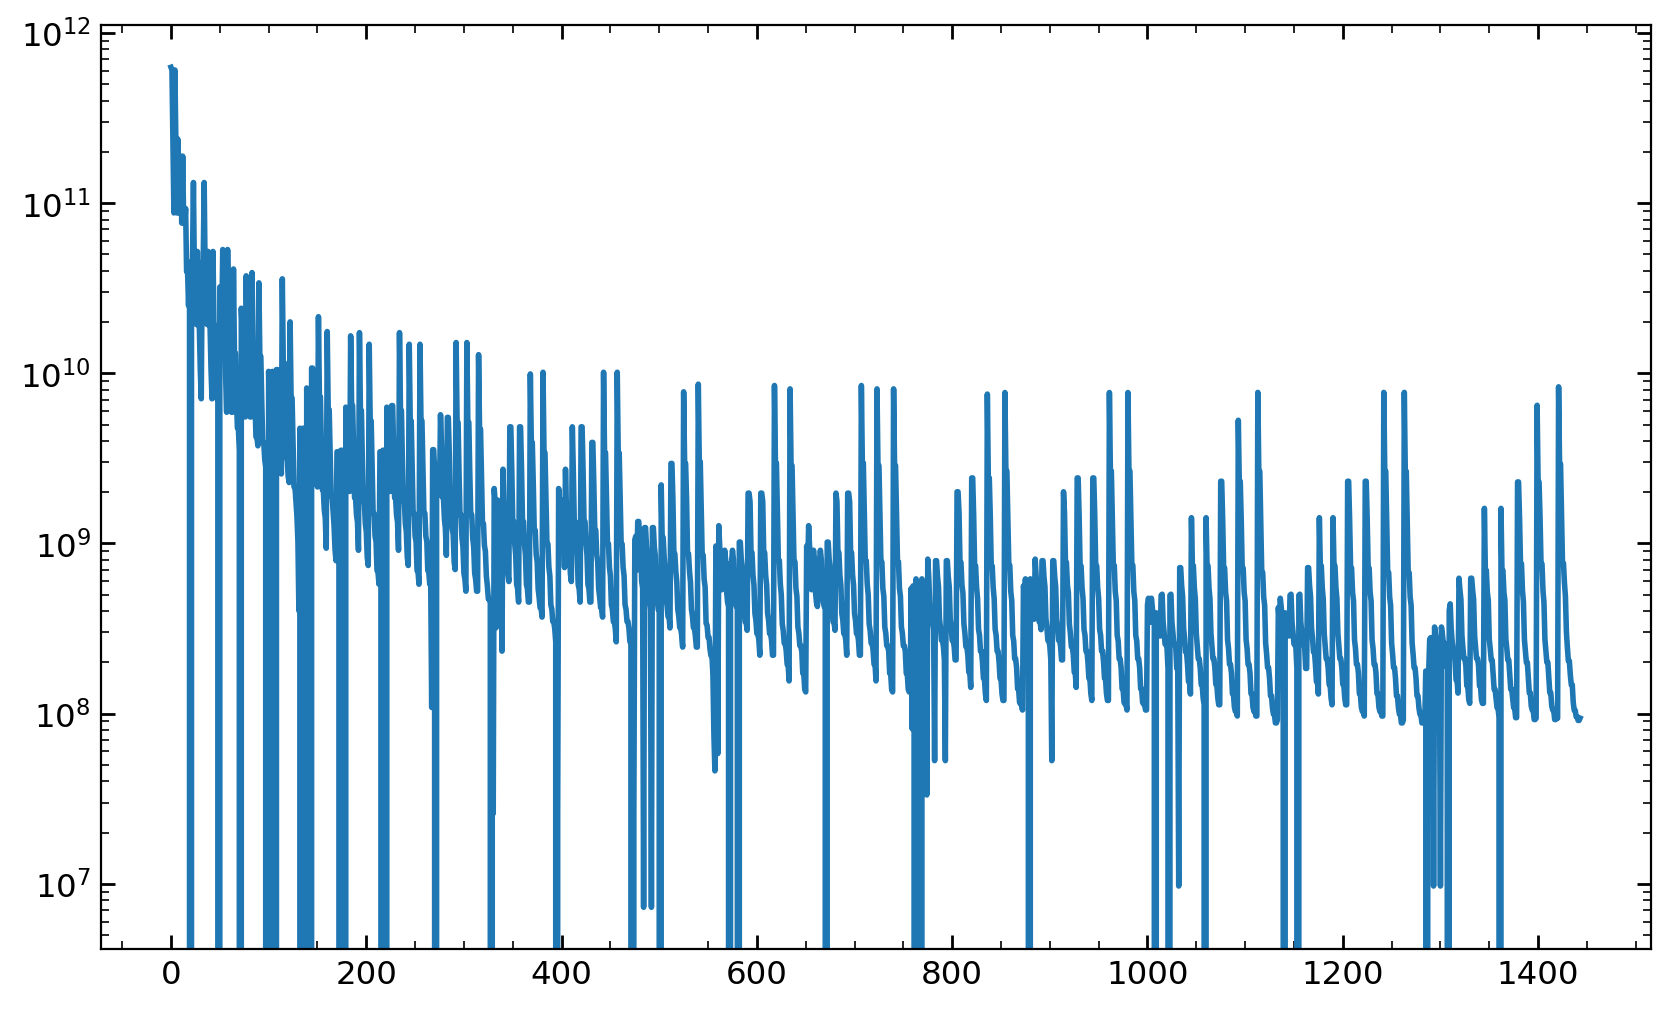

In [71]:
plt.semilogy()
plt.plot(Xout[0])

## Try inference with Shivam's data

In [4]:
filepath = '/anvil/scratch/x-mho1/cmass-ili/scratch/from_shivam/summary_stats_charm_truth_all_LH_onefile_rsd_sigpos_8.0.npy'
data = np.load(filepath, allow_pickle=True).item()

In [111]:
for k, v in data.items():
    print(k, v.shape)

Pk_mock_all (2000, 3, 17)
Pk_truth_all (2000, 3, 17)
Bk_mock_k0p06_all (2000, 6)
Bk_truth_k0p06_all (2000, 6)
Bk_mock_k0p2_all (2000, 6)
Bk_truth_k0p2_all (2000, 6)
Bk_mock_k0p3_all (2000, 6)
Bk_truth_k0p3_all (2000, 6)
s0_mock_all (2000, 3)
s0_truth_all (2000, 3)
s1_mock_all (2000, 36)
s1_truth_all (2000, 36)
s2_mock_all (2000, 198)
s2_truth_all (2000, 198)
cosmology_all (2000, 5)


In [112]:
from cmass.infer.loaders import preprocess_Pk, preprocess_Bk

Xtot = []
base = 'truth'
# base = 'mock'

# Pk0
X0 = []
for i in range(2000):
    X0.append({'k': np.linspace(0.001, 0.35, 17), 'value': data[f'Pk_{base}_all'][i,0]})
Xout = preprocess_Pk(X0, 0.4)
Xtot.append(Xout)

# Pk2
X = []
for i in range(2000):
    X.append({'k': np.linspace(0.001, 0.35, 17), 'value': data[f'Pk_{base}_all'][i,1]})
Xout = preprocess_Pk(X, 0.4, monopole=False, norm=X0)
Xtot.append(Xout)

# Pk4
X = []
for i in range(2000):
    X.append({'k': np.linspace(0.001, 0.35, 17), 'value': data[f'Pk_{base}_all'][i,2]})
Xout = preprocess_Pk(X, 0.4, monopole=False, norm=X0)
Xtot.append(Xout)

# Bk0
X = []
for i in range(2000):
    v = np.concatenate([data[k][i] for k in [f'Bk_{base}_k0p06_all', f'Bk_{base}_k0p2_all', f'Bk_{base}_k0p3_all']])
    o = {
        'k': np.linspace(0.001, 0.35, len(v)),
        'value': np.log10(v)
    }
    X.append(o)
Xout = preprocess_Bk(X, 0.4)
Xtot.append(Xout)

Xfinal = np.concatenate(Xtot, axis=-1)

theta = data['cosmology_all']
Xfinal.shape, theta.shape

((2000, 69), (2000, 5))

In [113]:
# np.random.seed(32)
# idx_test = np.random.choice(2000, 200, replace=False)
# idx_val = np.random.choice(np.setdiff1d(np.arange(2000), idx_test), 200, replace=False)
# idx_train = np.setdiff1d(np.arange(2000), np.concatenate([idx_test, idx_val]))

X_train = Xfinal[idx_train]
X_val = Xfinal[idx_val]
X_test = Xfinal[idx_test]
theta_train = theta[idx_train]
theta_val = theta[idx_val]
theta_test = theta[idx_test]

In [114]:
outpath = '/anvil/scratch/x-mho1/cmass-ili/shivamlike/fastpm/models/halo/Pk0+Pk2+Pk4+Bk0/kmax-0.4'

# np.save(join(outpath, 'idx_train.npy'), idx_train)
# np.save(join(outpath, 'x_train.npy'), X_train)
# np.save(join(outpath, 'theta_train.npy'), theta_train)

# np.save(join(outpath, 'idx_val.npy'), idx_val)
# np.save(join(outpath, 'x_val.npy'), X_val)
# np.save(join(outpath, 'theta_val.npy'), theta_val)

np.save(join(outpath, 'idx_test.npy'), idx_test)
np.save(join(outpath, 'x_test.npy'), X_test)
np.save(join(outpath, 'theta_test.npy'), theta_test)

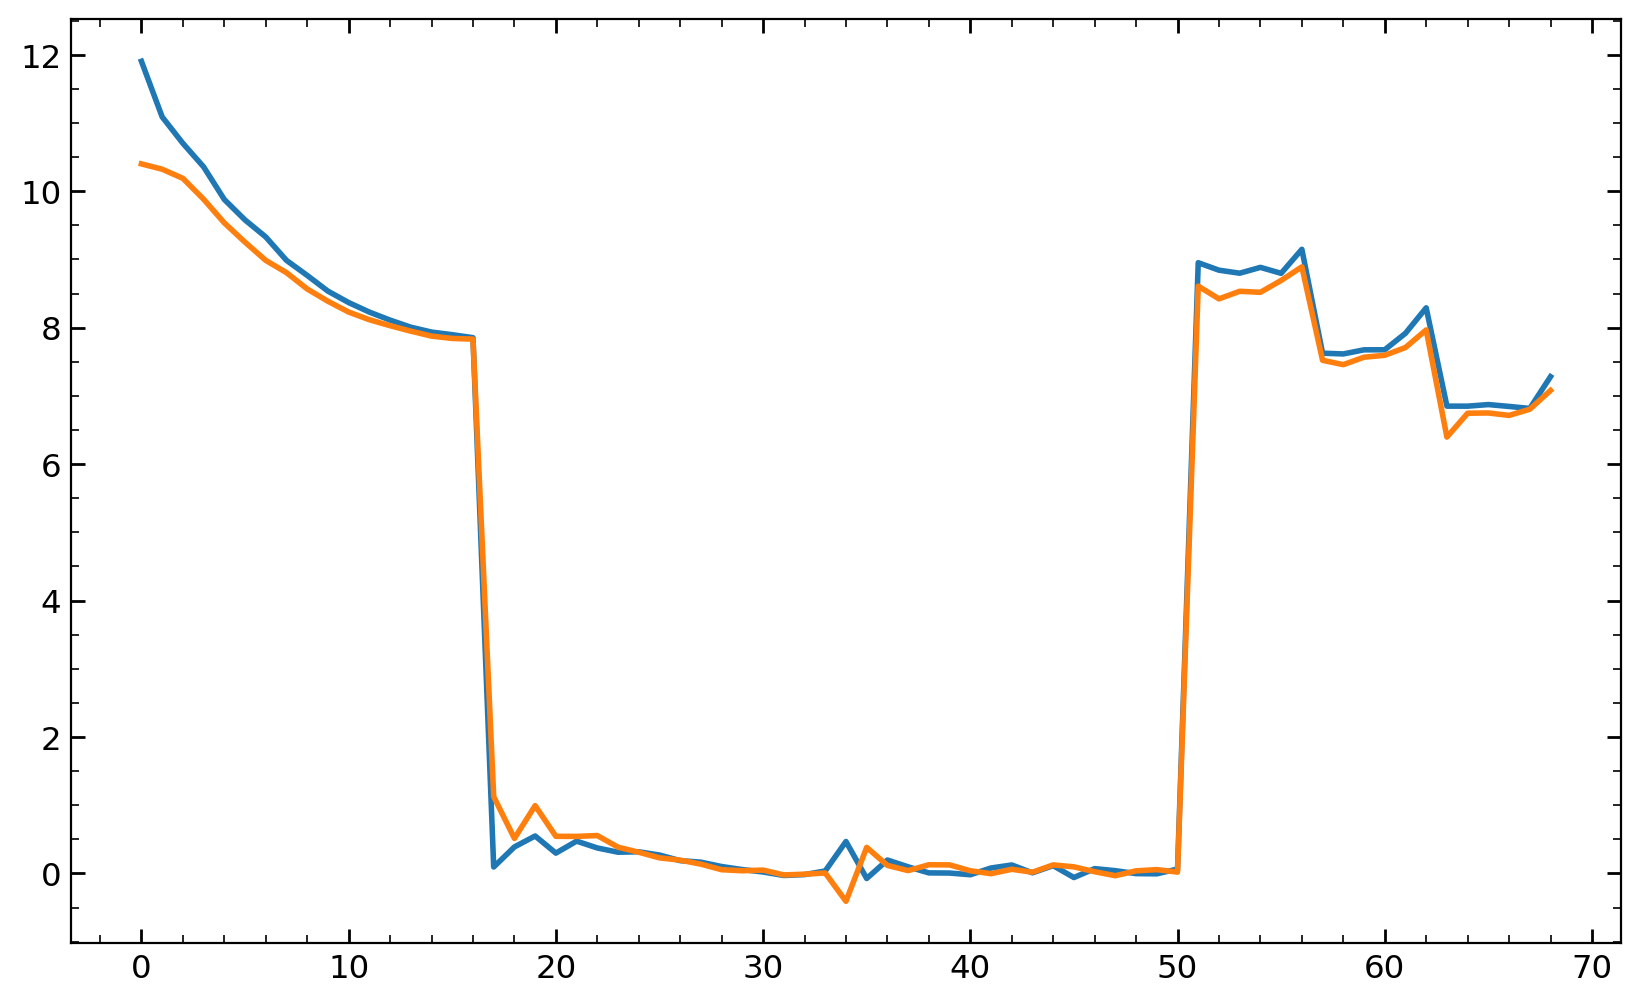

In [115]:
plt.plot(X_test[10])
plt.plot(X_train[10])

## Examine Shivam models

In [7]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames# +hodnames

# Specify model configuration
nbody = 'shivamlike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

In [11]:
# Specify data dtype
tracer = 'halo'
summaries = ['zPk0', 'zPk2', 'zPk4', 'zBk0']
summary = '+'.join(summaries)
kmax = 0.4
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
# os.listdir(modelpath)

In [10]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

(0.0, 1.0, 0.0, 1.0)

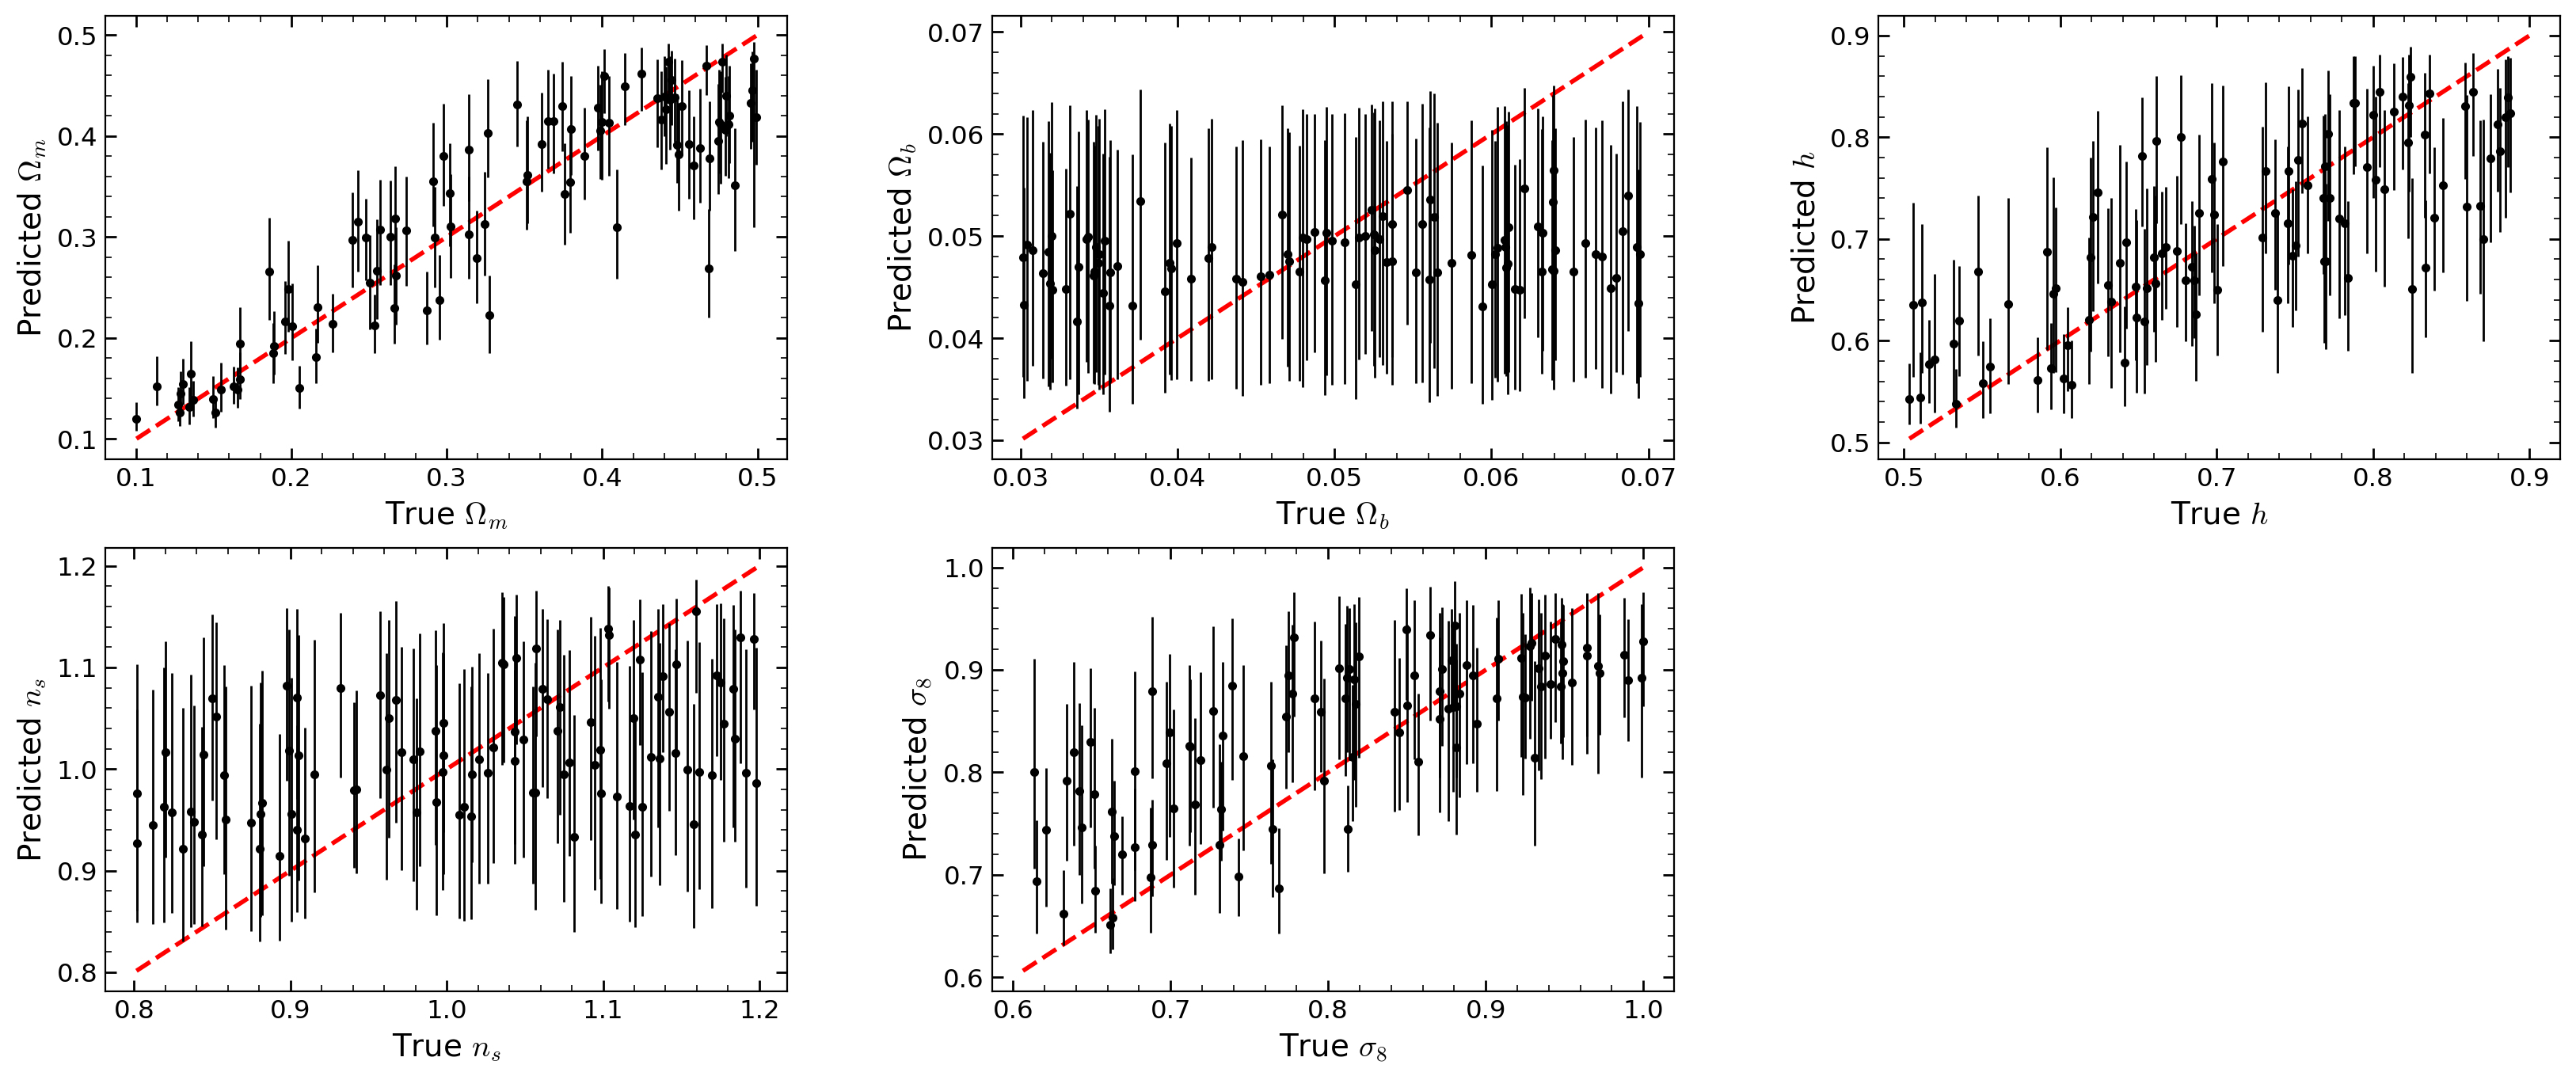

In [17]:
ss = 2

N = len(names)
f, axs = plt.subplots(2, N//2+1, figsize=(20, 8), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs[:-1]):
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
axs[-1].axis('off')

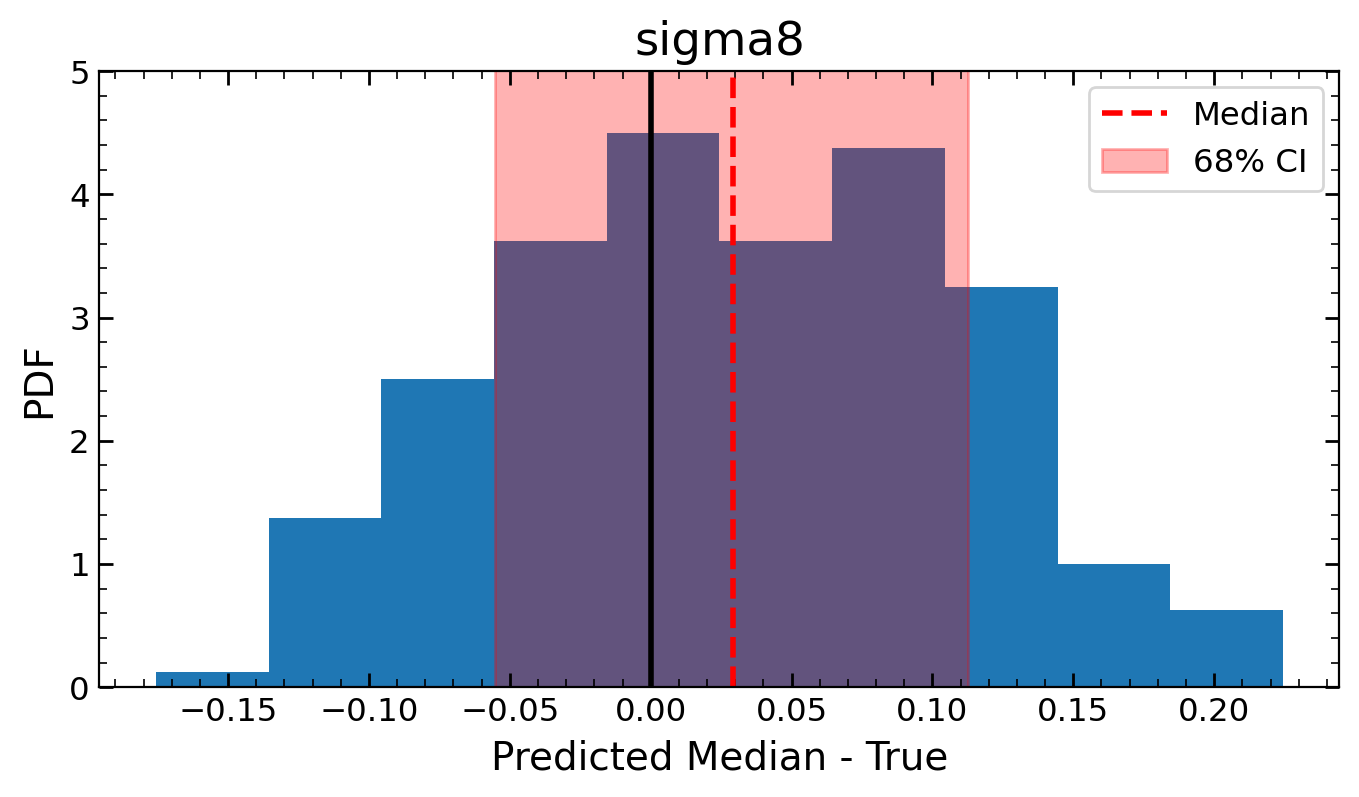

In [29]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))
x_ = percs[1, :, -1] - ytest[:,-1]
ax.hist(x_, density=True)
p_ = np.percentile(x_, [16, 84, 50])
ax.axvline(p_[2], color='r', ls='--', label='Median')
ax.fill_between(p_[:2], 0, 10, color='r', alpha=0.3, label='68% CI')
ax.axvline(0, color='k', ls='-')
ax.set_ylim(0,5)
ax.set(xlabel='Predicted Median - True', ylabel='PDF')
ax.set_title('sigma8')
ax.legend()

## Test noising Bk

In [6]:
from cmass.utils import cosmo_to_astropy
from cmass.infer.loaders import get_cosmo
from copy import deepcopy

wdir = '/anvil/scratch/x-mho1/cmass-ili'
# Specify model configuration
nbody = 'quijote'
sim = 'nbody'
L, N = 1000, 128

lhid = 3
a = str(0.666667)
z = 1/float(a) - 1

sourcepath = join(wdir, nbody, sim, f'L{L}-N{N}/{lhid}')
filepath = join(sourcepath, 'halos.h5')
with h5py.File(filepath, 'r') as f:
    qpos = f[a]['pos'][:]
    qvel = f[a]['vel'][:]
    qmass = f[a]['mass'][:]
cosmo = get_cosmo(sourcepath)
cosmo = cosmo_to_astropy(cosmo)

In [123]:
mpos = (qpos // (1000/128) + 0.5) * 1000/128
mvel = deepcopy(qvel)

In [124]:
np.random.seed(32)
Lnoise = (L/N)/np.sqrt(3)
qpos += np.random.normal(0, Lnoise, qpos.shape)
mpos += np.random.normal(0, Lnoise, mpos.shape)

In [125]:
from cmass.diagnostics.summ import (
    get_mesh_resolution, run_pylians,
    MA, MAz
)
cache_dir = join(wdir, 'scratch', 'cache')

def summ(pos, vel):
    Nmesh, MAS = get_mesh_resolution(L, high_res=True)
    field = MAz(pos, vel, L, Nmesh, cosmo, z, MAS=MAS, axis=0)
    out1 = run_pylians(
        field, ['Pk'], L, axis=0, MAS=MAS,
        num_threads=16, use_rsd=True
    )

    Nmesh, MAS = get_mesh_resolution(L, high_res=False)
    field = MAz(pos, vel, L, Nmesh, cosmo, z, MAS=MAS, axis=0)
    out2 = run_pylians(
        field, ['Bk'], L, axis=0, MAS=MAS,
        num_threads=16, use_rsd=True, cache_dir=cache_dir
    )
    out = {**out1, **out2}
    return out

In [126]:
o1 = summ(mpos, mvel)
o2 = summ(qpos, qvel)
print(o1.keys())

[22:42:30-INFO] Running calcBk_bfast...
[22:42:38-INFO] Finished calcBk_bfast... (0m8s)
[22:42:39-INFO] Running calcBk_bfast...
[22:42:42-INFO] Finished calcBk_bfast... (0m3s)


dict_keys(['zPk_k3D', 'zPk', 'zBk_k123', 'zBk', 'zQk', 'zbPk_k3D', 'zbPk'])


Text(0.5, 0.98, 'Meshed Quijote / True Quijote')

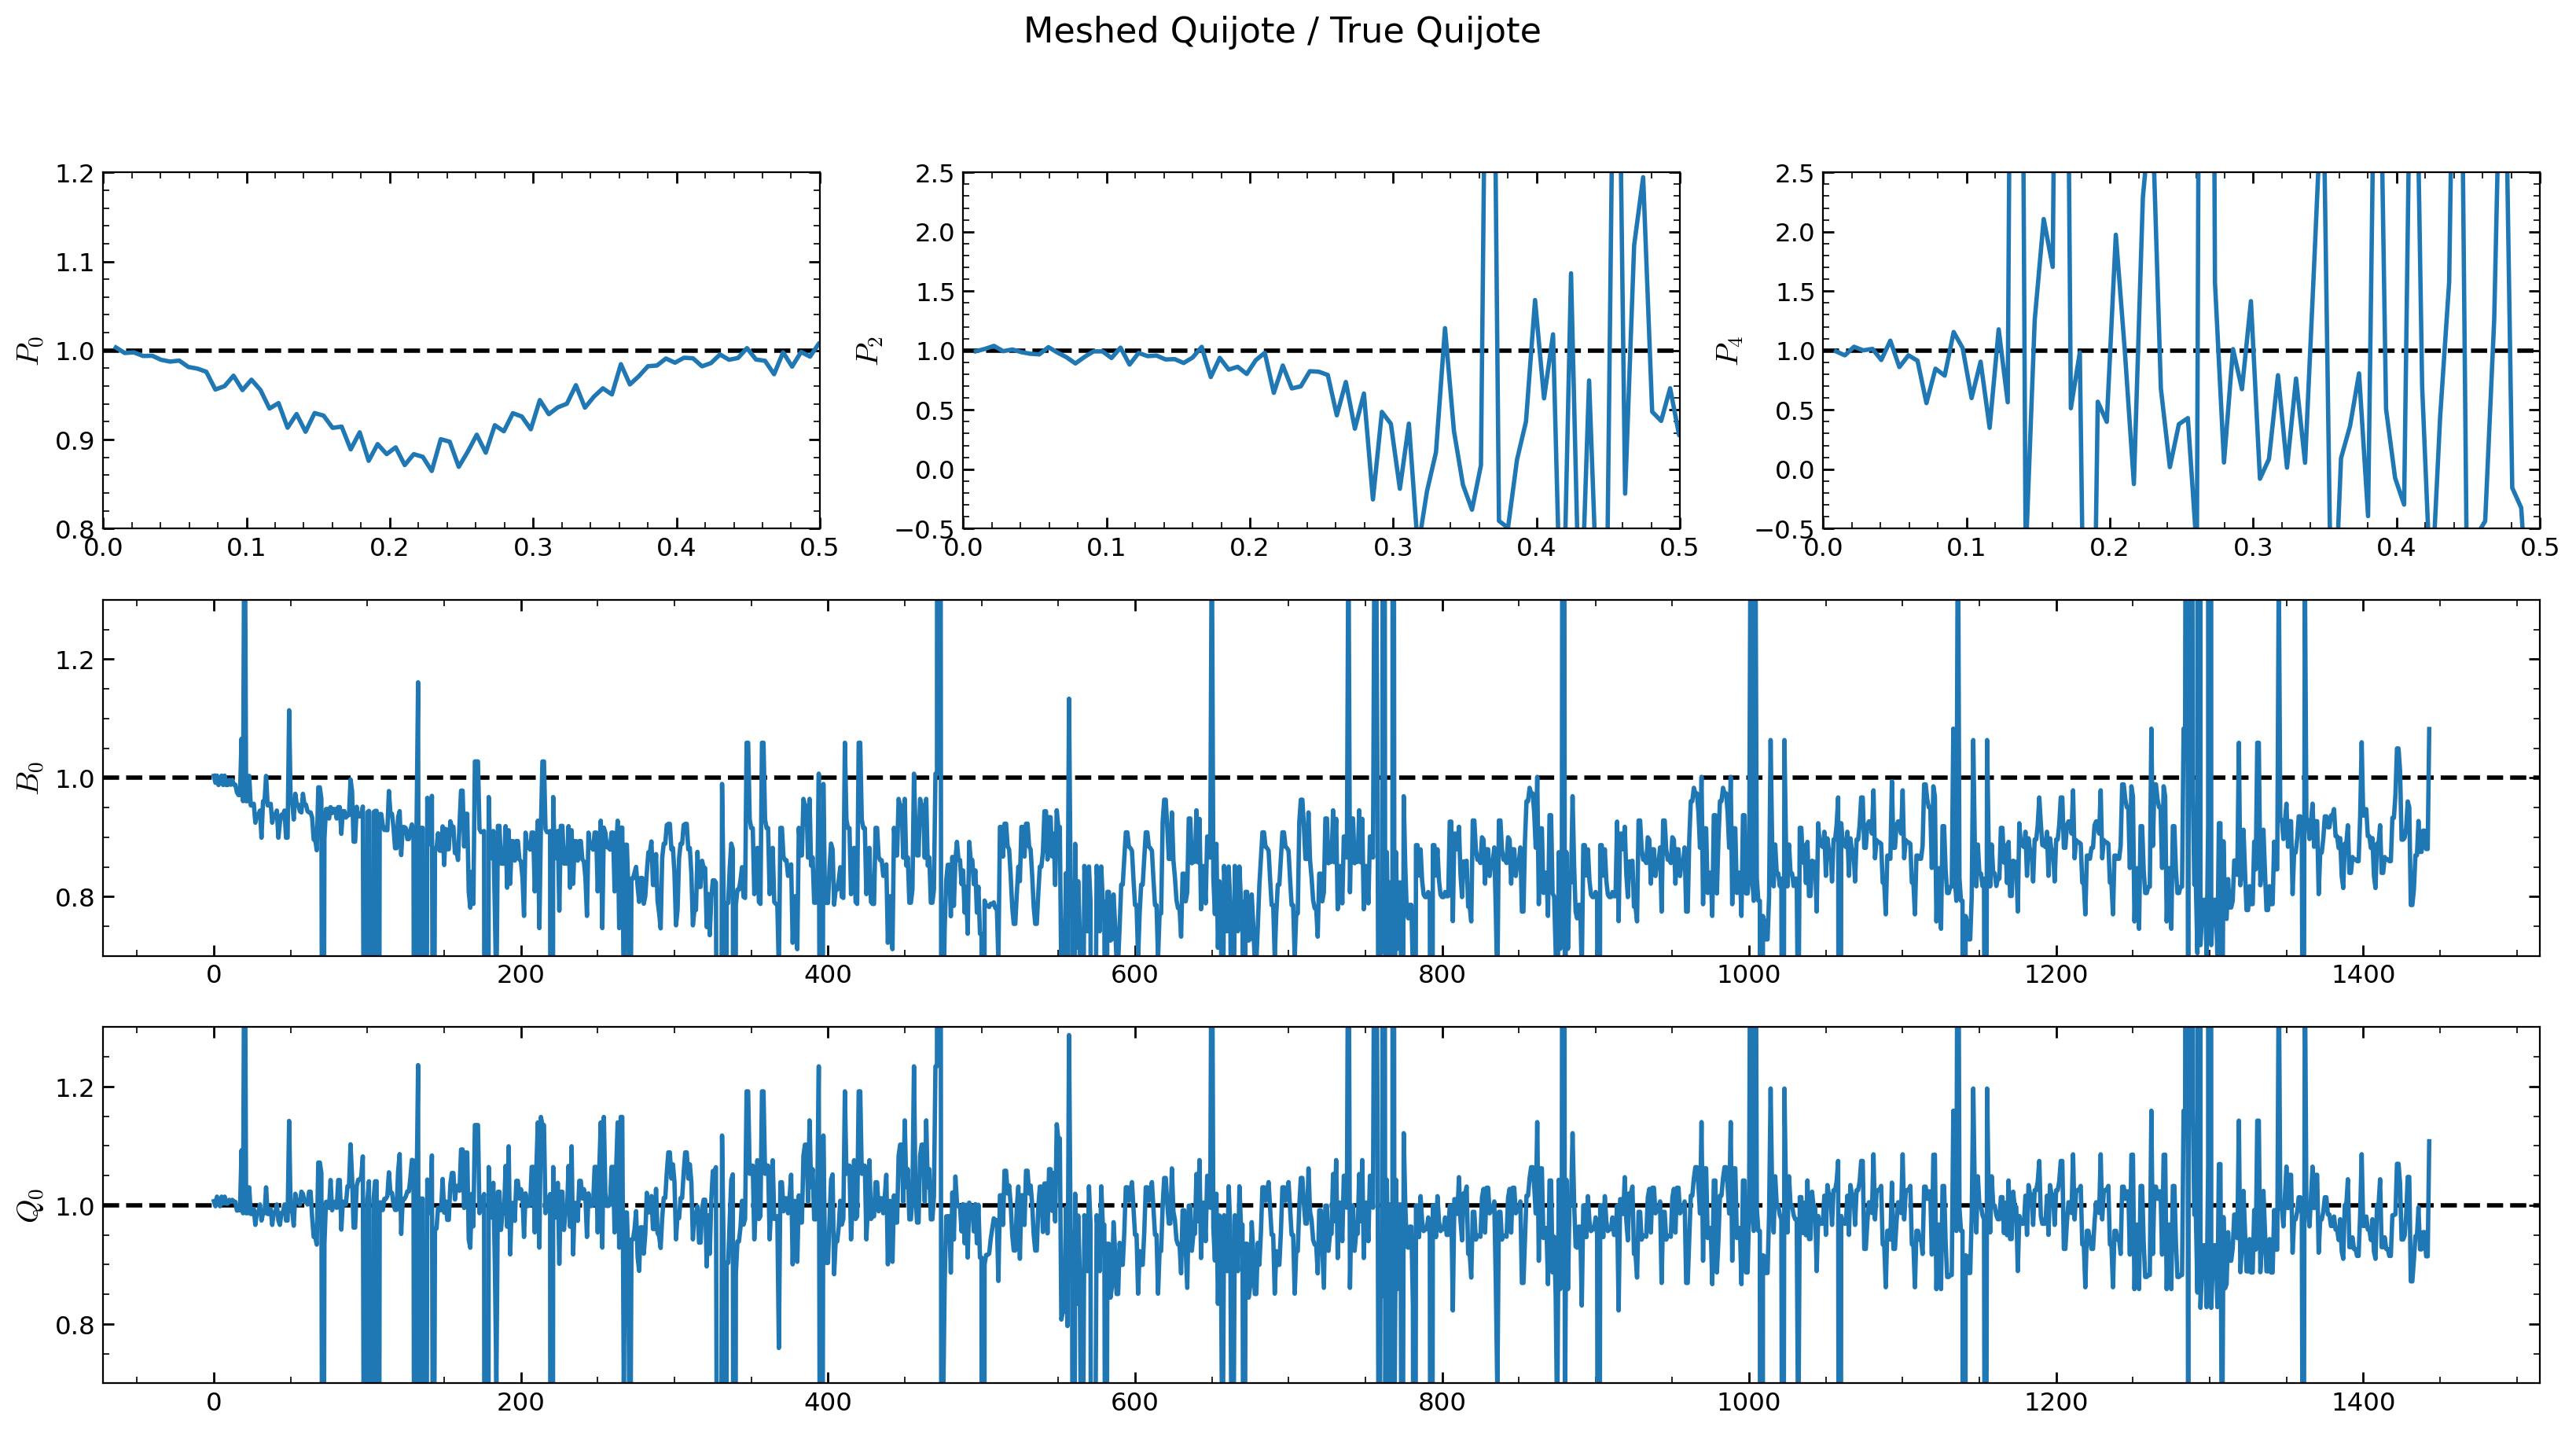

In [127]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 3, figure=fig)

# Pk0
ax = fig.add_subplot(gs[0, 0])
ax.axhline(1, color='k', ls='--')
ax.plot(o1['zPk_k3D'], o1['zPk'][:,0]/o2['zPk'][:,0])
ax.set_xlim(0, 0.5)
ax.set_ylim(0.8, 1.2)
ax.set(ylabel=r'$P_0$')

# Pk2
ax = fig.add_subplot(gs[0, 1])
ax.axhline(1, color='k', ls='--')
ax.plot(o1['zPk_k3D'], o1['zPk'][:,1]/o2['zPk'][:,1])
ax.set_xlim(0, 0.5)
ax.set_ylim(-0.5, 2.5)
ax.set(ylabel=r'$P_2$')

# Pk4
ax = fig.add_subplot(gs[0, 2])
ax.axhline(1, color='k', ls='--')
ax.plot(o1['zPk_k3D'], o1['zPk'][:,2]/o2['zPk'][:,2])
ax.set_xlim(0, 0.5)
ax.set_ylim(-0.5, 2.5)
ax.set(ylabel=r'$P_4$')

# Bk0
ax = fig.add_subplot(gs[1, :])
ax.axhline(1, color='k', ls='--')
ax.plot(o1['zBk'][0]/o2['zBk'][0])
ax.set_ylim(0.7, 1.3)
ax.set(ylabel=r'$B_0$')

# Qk0
ax = fig.add_subplot(gs[2, :])
ax.axhline(1, color='k', ls='--')
ax.plot(o1['zQk'][0]/o2['zQk'][0])
ax.set_ylim(0.7, 1.3)
ax.set(ylabel=r'$Q_0$')

fig.suptitle('Meshed Quijote / True Quijote', fontsize=16)

In [84]:
o2['zBk'][0]

array([1.6671679e+12, 1.8031915e+12, 4.9589200e+11, ..., 8.0785824e+07,
       8.0785824e+07, 7.7625656e+07], dtype=float32)

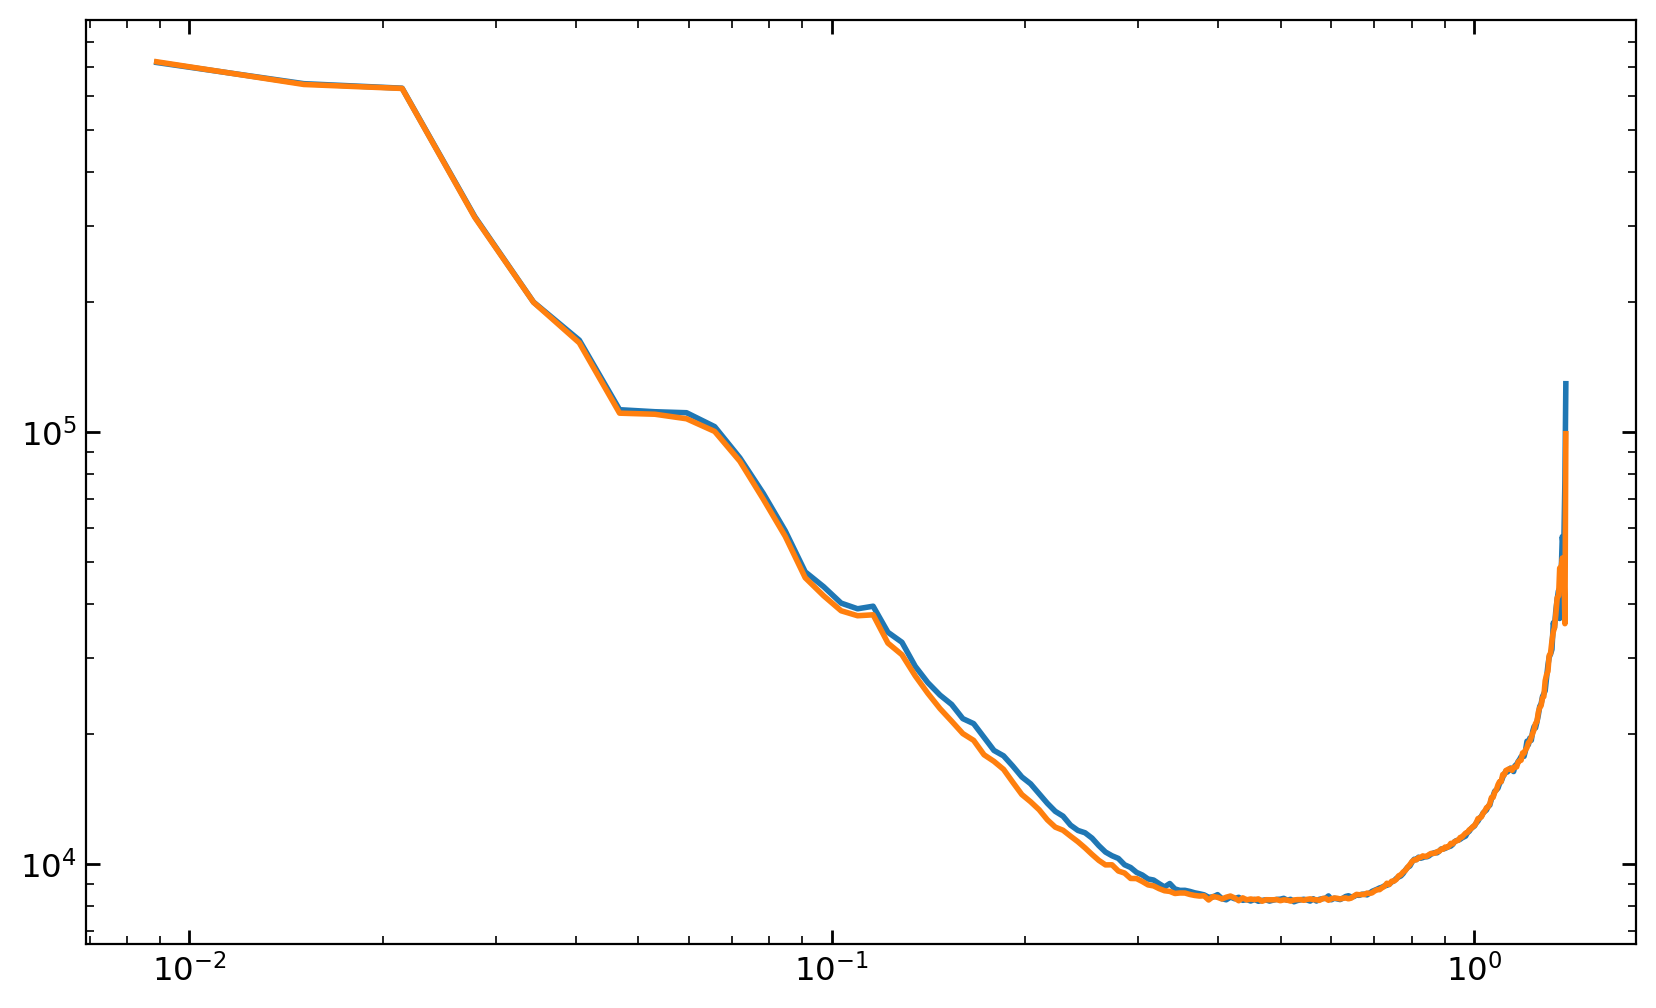

In [57]:
plt.loglog()
k = out1['zPk_k3D']
v = out1['zPk']
plt.plot(k, v[:,0])

k = out2['zPk_k3D']
v = out2['zPk']
plt.plot(k, v[:,0])

## Make halos.h5 for quijote/meshed

In [5]:
from cmass.utils import cosmo_to_astropy
from cmass.infer.loaders import get_cosmo
from copy import deepcopy

wdir = '/anvil/scratch/x-mho1/cmass-ili'
# Specify model configuration
nbody = 'quijote'
sim = 'nbody'
L, N = 1000, 128

a = str(0.666667)
z = 1/float(a) - 1

for lhid in tqdm(range(2000)):
    lhid = str(lhid)
    sourcepath = join(wdir, nbody, sim, f'L{L}-N{N}/{lhid}')
    filepath = join(sourcepath, 'halos.h5')
    with h5py.File(filepath, 'r') as f:
        qpos = f[a]['pos'][:]
        qvel = f[a]['vel'][:]
        qmass = f[a]['mass'][:]
    cosmo = get_cosmo(sourcepath)
    cosmo = cosmo_to_astropy(cosmo)

    mpos = (qpos // (1000/128) + 0.5) * 1000/128

    outpath = join(wdir, nbody, 'meshed', f'L{L}-N{N}/{lhid}')
    with h5py.File(join(outpath, 'halos.h5'), 'w') as f:
        g = f.create_group(a)
        g.create_dataset('pos', data=mpos)
        g.create_dataset('vel', data=qvel)
        g.create_dataset('mass', data=qmass)

100%|██████████| 2000/2000 [02:20<00:00, 14.22it/s]


## Model it visually